# Задание 5. Анализ данных пассажиров "Титаника" и построение моделей предсказания выживаемости

## 1. Загрузка исходных данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# RandomForestClassifier был импортирован, но не использовался в оригинальном коде.
# Если нужен, можно раскомментировать:
# from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, \
                            precision_score, recall_score, f1_score, roc_auc_score

# Настройки для отображения
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Загрузка данных
try:
    data = pd.read_csv('datas/titanic.csv')
    print("Данные успешно загружены.")
except FileNotFoundError:
    print("Ошибка: Файл titanic.csv не найден.")
    exit()

print("Первые 5 строк данных:")
data.head()

Данные успешно загружены.
Первые 5 строк данных:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Выполнение анализа данных

In [3]:
# Основная информация о данных
print("Информация о датасете:")
data.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Описательная статистика
print("\nОписательная статистика (числовые признаки):")
print(data.describe())
print("\nОписательная статистика (категориальные признаки):")
print(data.describe(include=['object']))


Описательная статистика (числовые признаки):
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  

Описательная статистика (категориа

In [5]:
# Проверка на пропущенные значения
print("\nПропущенные значения по столбцам:")
print(data.isnull().sum())


Пропущенные значения по столбцам:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


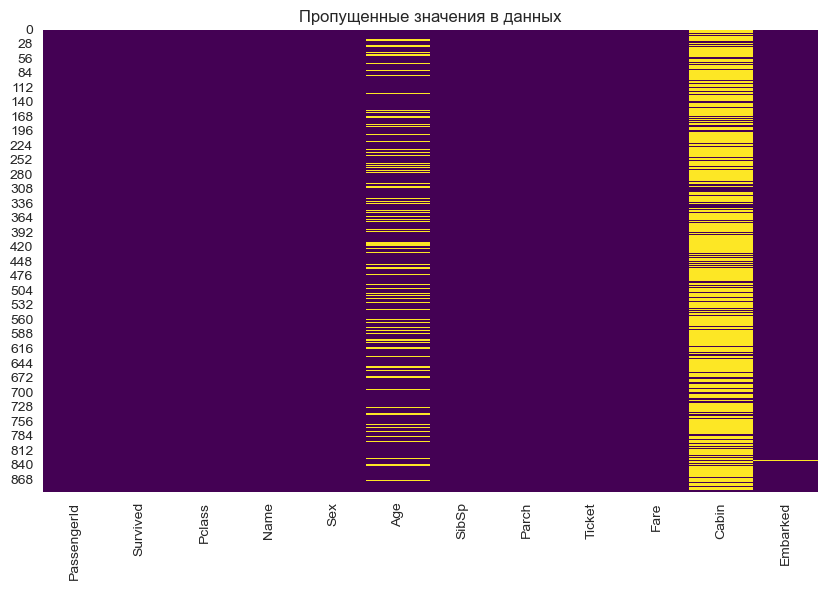

In [6]:
# Визуализация пропущенных значений
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в данных')
plt.show()

### Ответы на вопросы:


--- Влияние класса каюты (Pclass) на выживаемость ---
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


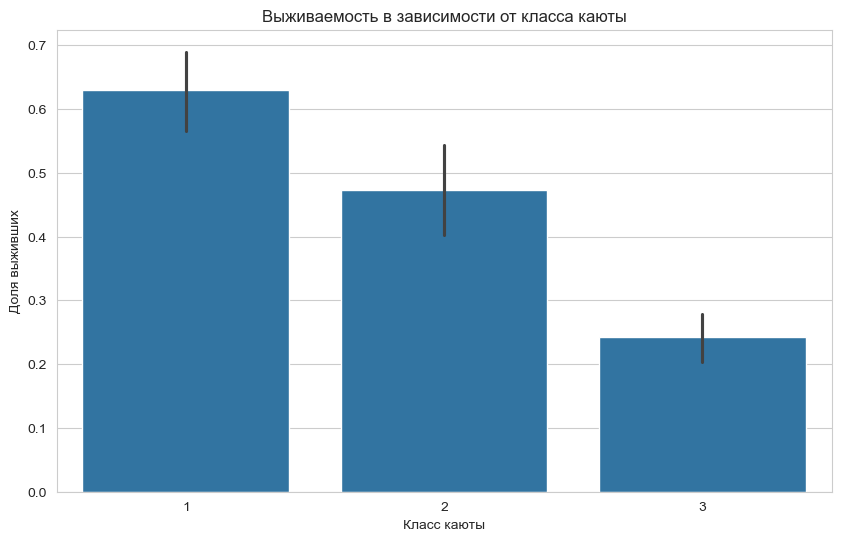

Вывод: Пассажиры 1-го класса имели значительно более высокие шансы на выживание, в то время как пассажиры 3-го класса - самые низкие.


In [7]:
# Влияет ли класс размещения пассажира на выживаемость? Если да, то как?
print("\n--- Влияние класса каюты (Pclass) на выживаемость ---")
pclass_survival = data.groupby('Pclass')['Survived'].mean()
print(pclass_survival)
sns.barplot(x='Pclass', y='Survived', data=data)
plt.title('Выживаемость в зависимости от класса каюты')
plt.ylabel('Доля выживших')
plt.xlabel('Класс каюты')
plt.show()
print("Вывод: Пассажиры 1-го класса имели значительно более высокие шансы на выживание, в то время как пассажиры 3-го класса - самые низкие.")


--- Выживаемость в зависимости от пола (Sex) ---
Процент выживших женщин: 74.20%
Процент выживших мужчин: 18.89%
        Выживших  Всего
Sex                    
female       233    314
male         109    577


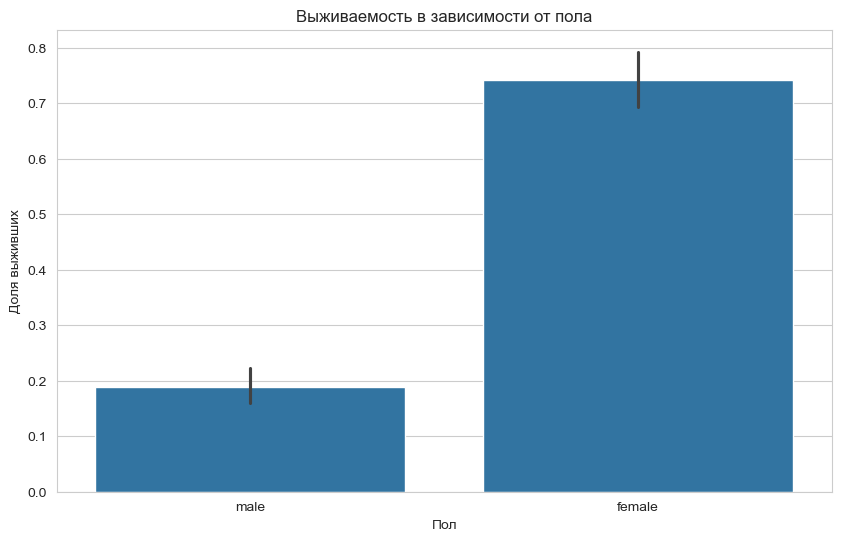

Вывод: Женщины имели значительно более высокие шансы на выживание по сравнению с мужчинами.


In [8]:
# Сколько женщин и мужчин выжило (дать ответ в процентном соотношении)?
print("\n--- Выживаемость в зависимости от пола (Sex) ---")
gender_survival_percentage = data.groupby('Sex')['Survived'].mean() * 100
print(f"Процент выживших женщин: {gender_survival_percentage['female']:.2f}%")
print(f"Процент выживших мужчин: {gender_survival_percentage['male']:.2f}%")

sex_survival_counts = data.groupby('Sex')['Survived'].agg(['sum', 'count'])
sex_survival_counts.rename(columns={'sum': 'Выживших', 'count': 'Всего'}, inplace=True)
print(sex_survival_counts)

sns.barplot(x='Sex', y='Survived', data=data)
plt.title('Выживаемость в зависимости от пола')
plt.ylabel('Доля выживших')
plt.xlabel('Пол')
plt.show()
print("Вывод: Женщины имели значительно более высокие шансы на выживание по сравнению с мужчинами.")


--- Анализ по возрасту (Age) ---
Минимальный возраст: 0.4 лет
Максимальный возраст: 80.0 лет
Средний возраст: 29.7 лет (среди известных)
Медианный возраст: 28.0 лет (среди известных)

Выживаемость по возрастным группам:
                          Доля выживших  Количество пассажиров
AgeGroup                                                      
Ребенок (0-12)                 0.579710                     69
Подросток (13-18)              0.428571                     70
Взрослый (36-60)               0.400000                    195
Молодой взрослый (19-35)       0.353271                    535
Пожилой (61+)                  0.227273                     22


/var/folders/54/_lmmyy6j4d1662_55qvwd1k40000gn/T/ipykernel_38577/3566083621.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AgeGroup', y='Survived', data=data_age_analysis, palette='viridis')


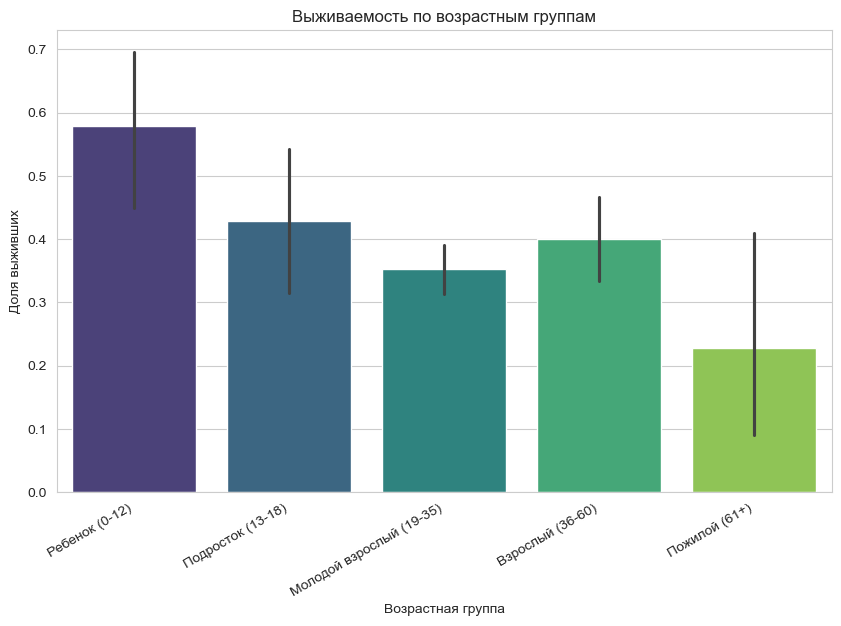

Вывод: Дети имели самые высокие шансы на выживание. Пожилые люди имели наименьшие шансы.


In [9]:
# Какой возраст самого молодого пассажира и самого взрослого? Какой средний возраст пассажиров?
# В какой возрастной группе было больше выживших, а в какой – меньше?
print("\n--- Анализ по возрасту (Age) ---")
print(f"Минимальный возраст: {data['Age'].min():.1f} лет")
print(f"Максимальный возраст: {data['Age'].max():.1f} лет")
print(f"Средний возраст: {data['Age'].mean():.1f} лет (среди известных)")
print(f"Медианный возраст: {data['Age'].median():.1f} лет (среди известных)")


# Для анализа возрастных групп, временно заполним пропуски медианой
data_age_analysis = data.copy()
data_age_analysis['Age'].fillna(data_age_analysis['Age'].median(), inplace=True)
data_age_analysis['AgeGroup'] = pd.cut(data_age_analysis['Age'],
                                       bins=[0, 12, 18, 35, 60, 100],
                                       labels=['Ребенок (0-12)', 'Подросток (13-18)',
                                               'Молодой взрослый (19-35)', 'Взрослый (36-60)',
                                               'Пожилой (61+)'])
age_group_survival = data_age_analysis.groupby('AgeGroup', observed=False)['Survived'].agg(['mean', 'count'])
age_group_survival.rename(columns={'mean': 'Доля выживших', 'count': 'Количество пассажиров'}, inplace=True)
print("\nВыживаемость по возрастным группам:")
print(age_group_survival.sort_values(by='Доля выживших', ascending=False))

sns.barplot(x='AgeGroup', y='Survived', data=data_age_analysis, palette='viridis')
plt.title('Выживаемость по возрастным группам')
plt.ylabel('Доля выживших')
plt.xlabel('Возрастная группа')
plt.xticks(rotation=30, ha='right')
plt.show()
print("Вывод: Дети имели самые высокие шансы на выживание. Пожилые люди имели наименьшие шансы.")



--- Анализ по количеству братьев/сестер/супругов (SibSp) ---
Максимальное число родственников (SibSp): 8
Доля людей, путешествующих СОВСЕМ в одиночку (SibSp=0 и Parch=0): 60.27%


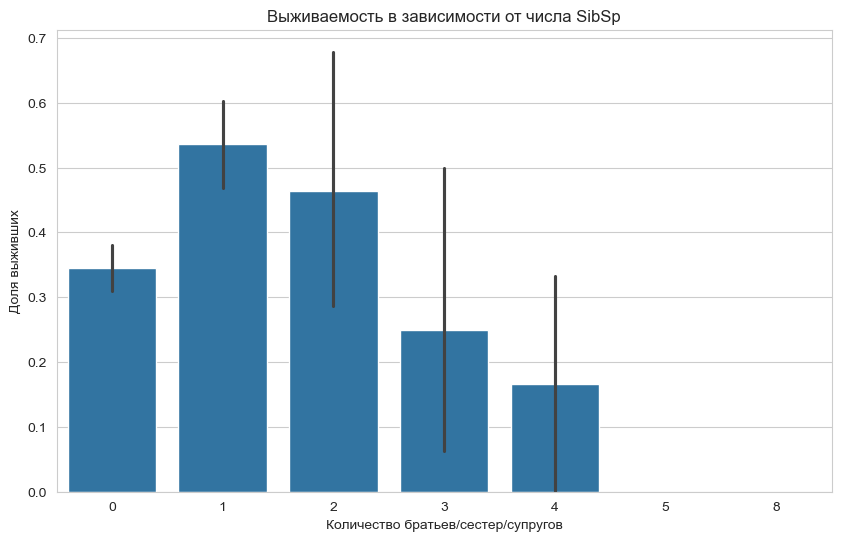

In [10]:
# Какое максимальное число родственников (SibSp) путешествовали вместе?
# Какова доля людей, путешествующих в одиночку?
print("\n--- Анализ по количеству братьев/сестер/супругов (SibSp) ---")
print(f"Максимальное число родственников (SibSp): {data['SibSp'].max()}")

# Доля людей, путешествующих в одиночку (SibSp=0 И Parch=0)
alone_count = len(data[(data['SibSp'] == 0) & (data['Parch'] == 0)])
percentage_alone = (alone_count / len(data)) * 100
print(f"Доля людей, путешествующих СОВСЕМ в одиночку (SibSp=0 и Parch=0): {percentage_alone:.2f}%")

sns.barplot(x='SibSp', y='Survived', data=data)
plt.title('Выживаемость в зависимости от числа SibSp')
plt.ylabel('Доля выживших')
plt.xlabel('Количество братьев/сестер/супругов')
plt.show()


--- Анализ по количеству родителей/детей (Parch) ---
Максимальное число родителей/детей (Parch): 6


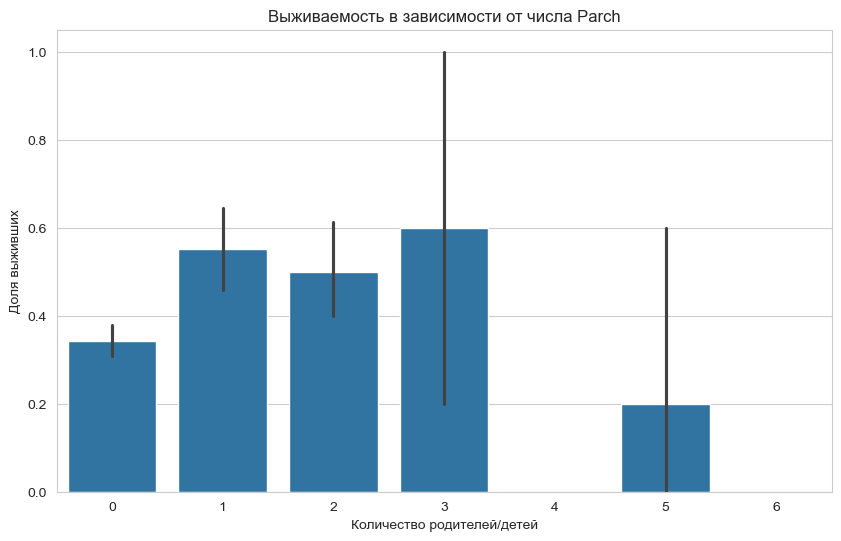

Вывод: Небольшое количество родственников (1-3 суммарно SibSp+Parch) могло повышать шансы на выживание, в то время как путешествие в одиночку или с очень большой семьей - понижать.


In [11]:
# Какое максимальное число родителей и детей (Parch) путешествовали вместе?
print("\n--- Анализ по количеству родителей/детей (Parch) ---")
print(f"Максимальное число родителей/детей (Parch): {data['Parch'].max()}")

sns.barplot(x='Parch', y='Survived', data=data)
plt.title('Выживаемость в зависимости от числа Parch')
plt.ylabel('Доля выживших')
plt.xlabel('Количество родителей/детей')
plt.show()
print("Вывод: Небольшое количество родственников (1-3 суммарно SibSp+Parch) могло повышать шансы на выживание, в то время как путешествие в одиночку или с очень большой семьей - понижать.")


--- Зависимость стоимости билета (Fare) и выживаемости ---


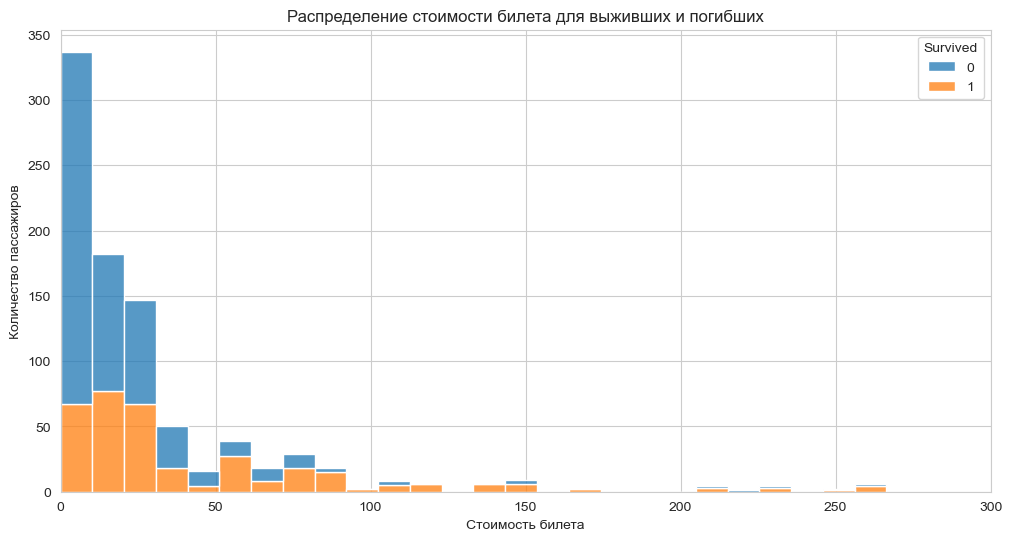

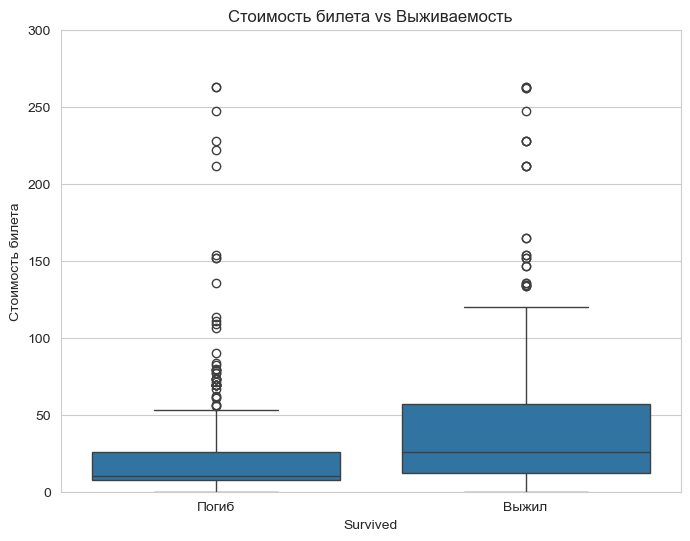

Вывод: Пассажиры, заплатившие больше за билет, имели более высокие шансы на выживание.


In [12]:
print("\n--- Зависимость стоимости билета (Fare) и выживаемости ---")
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='Fare', hue='Survived', multiple='stack', bins=50, kde=False)
plt.title('Распределение стоимости билета для выживших и погибших')
plt.xlabel('Стоимость билета')
plt.ylabel('Количество пассажиров')
plt.xlim(0, 300)
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x='Survived', y='Fare', data=data)
plt.title('Стоимость билета vs Выживаемость')
plt.xticks([0,1],['Погиб', 'Выжил'])
plt.ylabel('Стоимость билета')
plt.ylim(0, 300)
plt.show()
print("Вывод: Пассажиры, заплатившие больше за билет, имели более высокие шансы на выживание.")


--- Выживаемость в зависимости от порта посадки (Embarked) ---
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


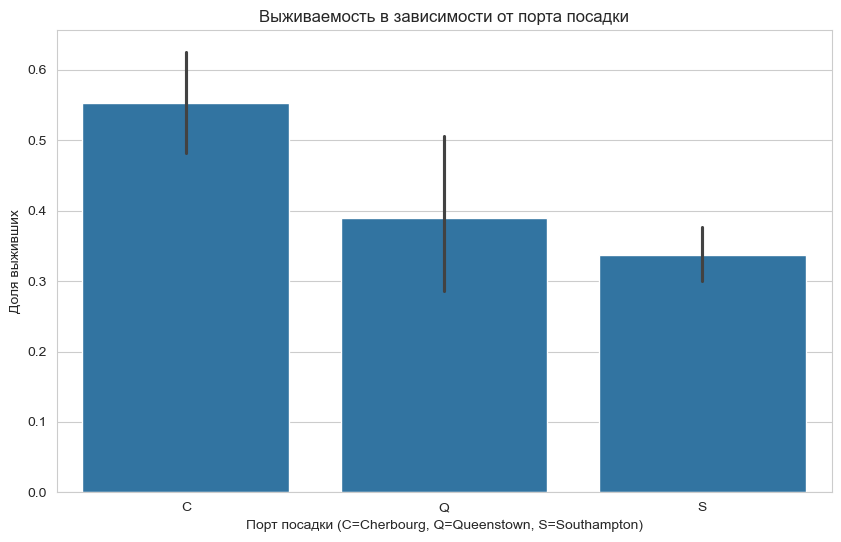

Вывод: Пассажиры, севшие в порту Шербур (C), имели самые высокие шансы на выживание.


In [13]:
print("\n--- Выживаемость в зависимости от порта посадки (Embarked) ---")
embarked_survival = data.groupby('Embarked')['Survived'].mean().sort_values(ascending=False)
print(embarked_survival)
sns.barplot(x='Embarked', y='Survived', data=data, order=['C', 'Q', 'S'])
plt.title('Выживаемость в зависимости от порта посадки')
plt.ylabel('Доля выживших')
plt.xlabel('Порт посадки (C=Cherbourg, Q=Queenstown, S=Southampton)')
plt.show()
print("Вывод: Пассажиры, севшие в порту Шербур (C), имели самые высокие шансы на выживание.")

## 3. Подготовка данных для дальнейшего анализа

In [14]:
# Удаление признаков, которые не будем использовать или требуют сложной обработки
# 'PassengerId' - идентификатор
# 'Name' - требует сложной обработки (например, извлечение титула)
# 'Ticket' - номера билетов часто уникальны или требуют сложного анализа
# 'Cabin' - слишком много пропущенных значений (более 77%)
data_processed = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Определяем категориальные и числовые признаки
# Pclass числовой, но по сути категориальный. Будем кодировать его как категориальный.
categorical_features = ['Pclass', 'Sex', 'Embarked']
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']

# Создание препроцессоров для числовых и категориальных данных
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Создание ColumnTransformer для применения разных трансформаций к разным столбцам
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Разделение на признаки (X) и целевую переменную (y)
X = data_processed.drop('Survived', axis=1)
y = data_processed['Survived']

In [15]:
# Проверка баланса классов
print("Баланс классов в целевой переменной 'Survived':")
print(y.value_counts(normalize=True))
# Дисбаланс не критичный, но можно учитывать при выборе метрик или использовать техники балансировки позже.

Баланс классов в целевой переменной 'Survived':
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


## 4. Разделение выборки на обучающую и тестовую

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Размер обучающей выборки X: {X_train.shape}")
print(f"Размер тестовой выборки X: {X_test.shape}")
print(f"Размер обучающей выборки y: {y_train.shape}")
print(f"Размер тестовой выборки y: {y_test.shape}")

Размер обучающей выборки X: (623, 7)
Размер тестовой выборки X: (268, 7)
Размер обучающей выборки y: (623,)
Размер тестовой выборки y: (268,)


## 5-7. Создание, обучение и тестирование моделей

### Вспомогательная функция для оценки моделей

In [17]:
all_metrics = {}

def evaluate_model(model_name, model, X_test_eval, y_test_eval):
    """Оценивает модель и выводит метрики, строит графики."""
    y_pred = model.predict(X_test_eval)
    y_proba = model.predict_proba(X_test_eval)[:, 1]

    accuracy = accuracy_score(y_test_eval, y_pred)
    precision = precision_score(y_test_eval, y_pred)
    recall = recall_score(y_test_eval, y_pred) # Полнота
    f1 = f1_score(y_test_eval, y_pred)
    roc_auc = roc_auc_score(y_test_eval, y_proba)

    cm = confusion_matrix(y_test_eval, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Особенность
    fall_out = fp / (fp + tn) if (fp + tn) > 0 else 0    # Выпадение (FPR)

    print(f"\n--- Метрики для модели: {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Полнота): {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity (Особенность): {specificity:.4f}")
    print(f"Fall-out (Выпадение, FPR): {fall_out:.4f}")

    metrics_dict = {
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
        'F1': f1, 'ROC_AUC': roc_auc, 'Specificity': specificity, 'Fall_out': fall_out
    }
    all_metrics[model_name] = metrics_dict

    # Матрица несоответствий
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Погиб', 'Выжил'], yticklabels=['Погиб', 'Выжил'])
    plt.xlabel('Предсказано')
    plt.ylabel('Фактически')
    plt.title(f'Матрица несоответствий для {model_name}')
    plt.show()

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y_test_eval, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

### 5. Дерево решений

Fitting 5 folds for each of 192 candidates, totalling 960 fits

Лучшие параметры для дерева решений: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Лучший ROC AUC на кросс-валидации: 0.8479

--- Метрики для модели: Дерево решений (Лучшее) ---
Accuracy: 0.7948
Precision: 0.8750
Recall (Полнота): 0.5437
F1-score: 0.6707
ROC AUC: 0.8295
Specificity (Особенность): 0.9515
Fall-out (Выпадение, FPR): 0.0485


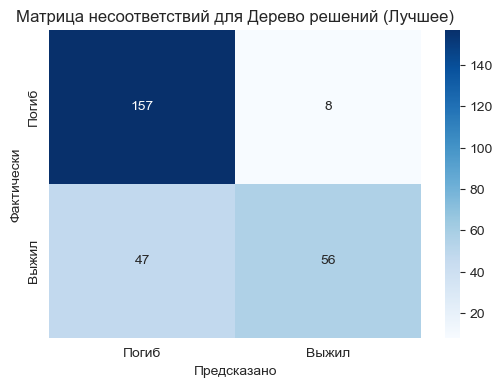

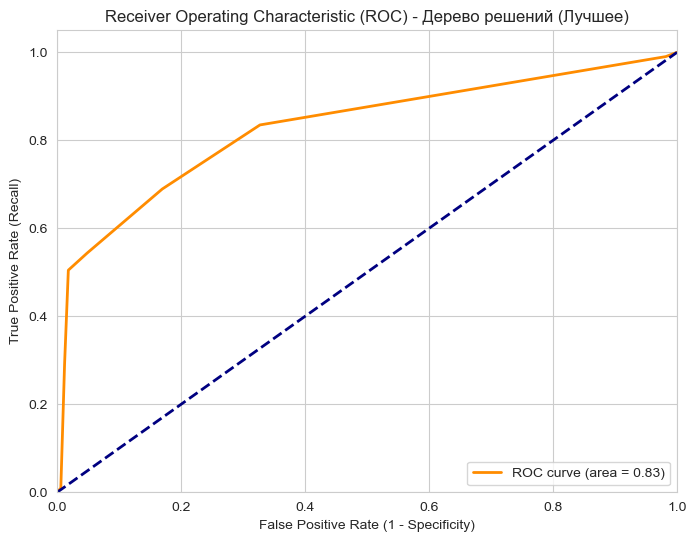

In [18]:
# Пайплайн для дерева решений
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42))])

# Параметры для GridSearchCV
param_grid_dt = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 3, 5, 7, 10, 15],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 10]
}

grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_dt.fit(X_train, y_train)

best_dt_model = grid_search_dt.best_estimator_
print(f"\nЛучшие параметры для дерева решений: {grid_search_dt.best_params_}")
print(f"Лучший ROC AUC на кросс-валидации: {grid_search_dt.best_score_:.4f}")

# Оценка лучшей модели дерева решений
evaluate_model("Дерево решений (Лучшее)", best_dt_model, X_test, y_test)

### 6. Визуализация и интерпретация дерева решений

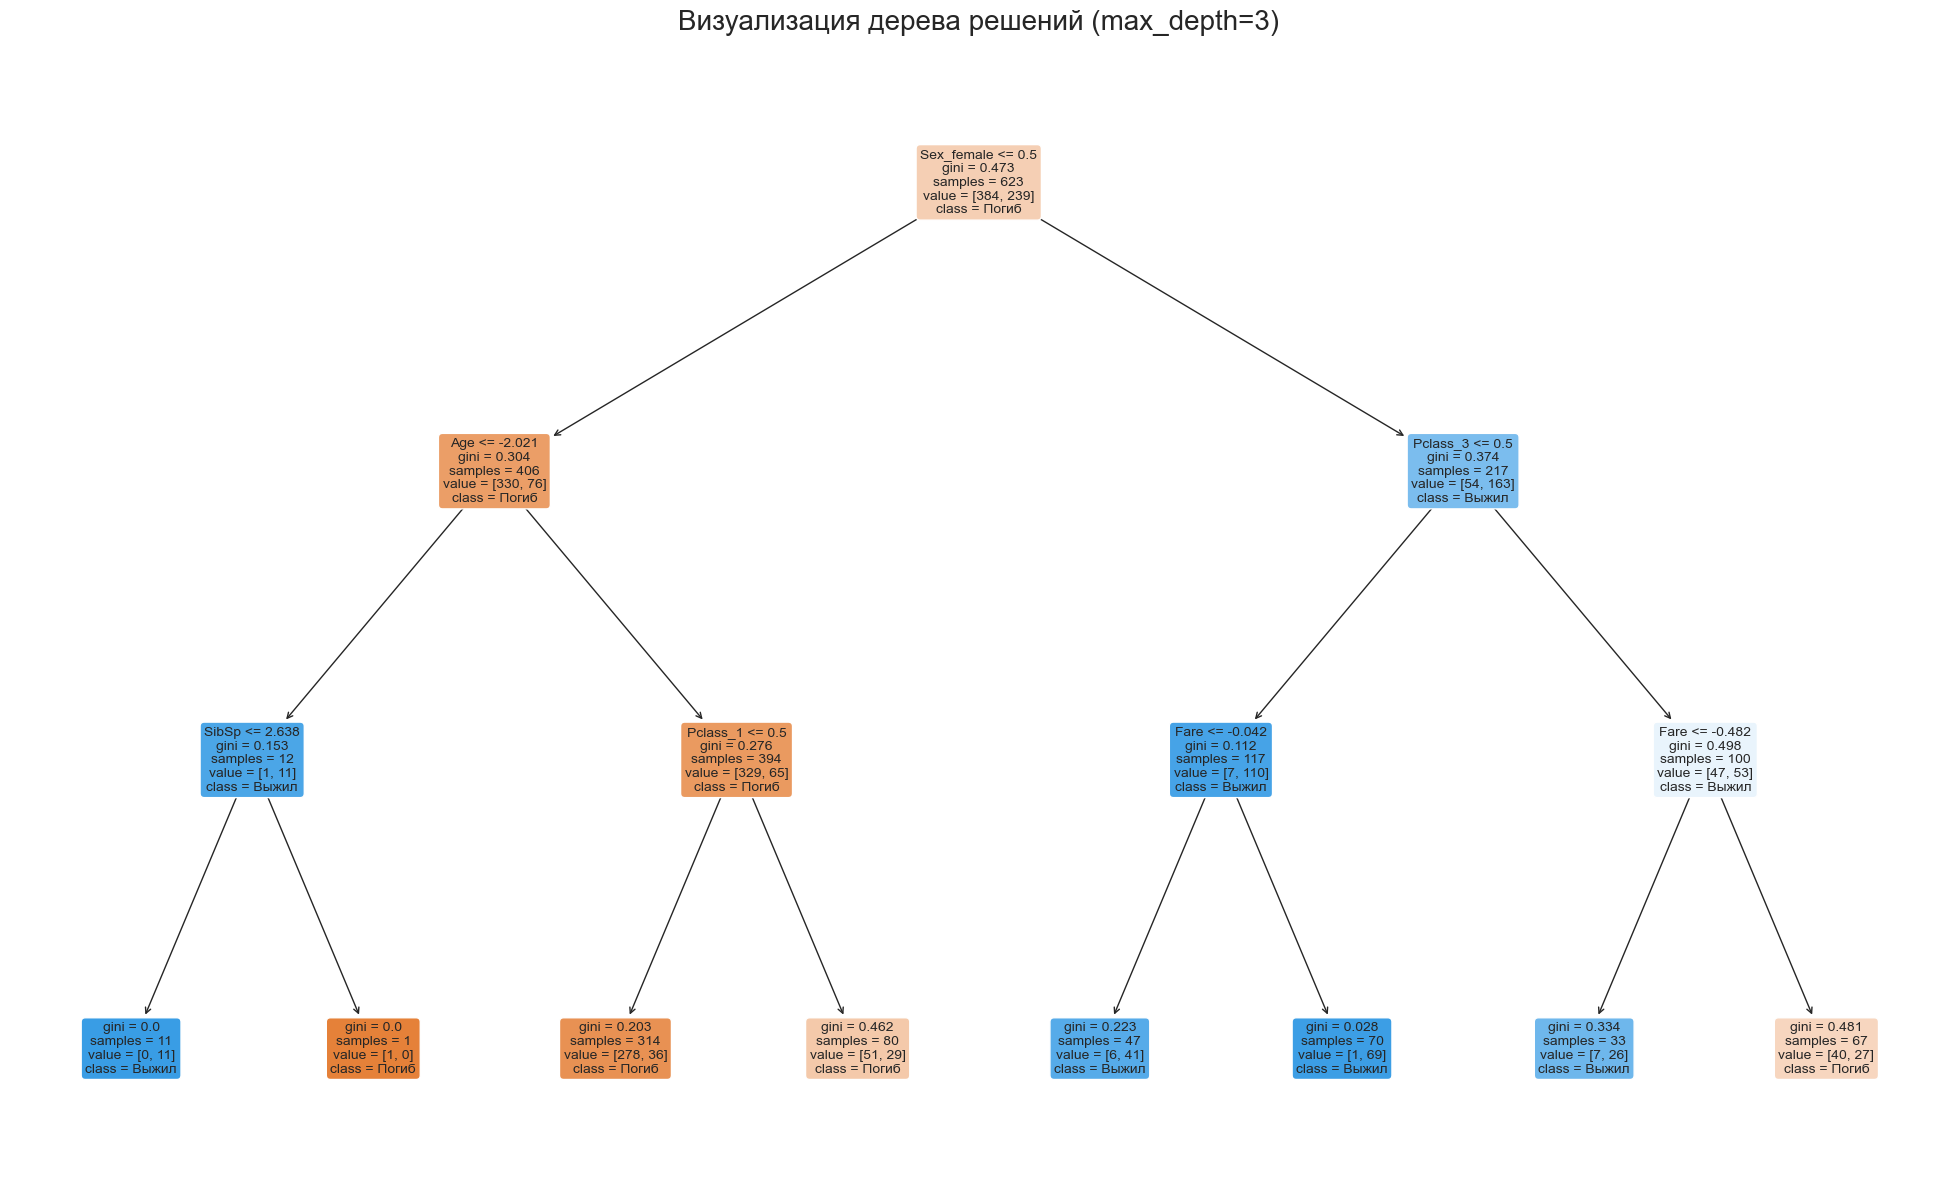

Интерпретация: Каждый узел показывает условие разделения (признак <= значение).
Значение 'value' показывает количество объектов каждого класса в узле.
Листья (терминальные узлы) показывают класс, к которому относится большинство объектов в листе.


In [19]:
# Получаем имена признаков после препроцессинга для визуализации
# preprocessor должен быть обучен на X_train
trained_preprocessor = best_dt_model.named_steps['preprocessor']
# numerical_feature_names = numerical_features # Они не меняют имена
categorical_feature_names_out = trained_preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
processed_feature_names = numerical_features + list(categorical_feature_names_out)

plt.figure(figsize=(25, 15)) # Размер может потребоваться настроить
plot_tree(best_dt_model.named_steps['classifier'],
          filled=True,
          rounded=True,
          class_names=['Погиб', 'Выжил'],
          feature_names=processed_feature_names,
          max_depth=3, # Ограничиваем глубину для читаемости, можно увеличить или убрать
          fontsize=10)
plt.title("Визуализация дерева решений (max_depth=3)", fontsize=20)
plt.show()
print("Интерпретация: Каждый узел показывает условие разделения (признак <= значение).")
print("Значение 'value' показывает количество объектов каждого класса в узле.")
print("Листья (терминальные узлы) показывают класс, к которому относится большинство объектов в листе.")

### 7. Другие методы классификации

#### K-ближайших соседей (KNN)

Лучшие параметры для KNN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'uniform'}
Лучший ROC AUC на кросс-валидации: 0.8528

--- Метрики для модели: K-ближайших соседей (KNN) ---
Accuracy: 0.8060
Precision: 0.8000
Recall (Полнота): 0.6602
F1-score: 0.7234
ROC AUC: 0.8518
Specificity (Особенность): 0.8970
Fall-out (Выпадение, FPR): 0.1030


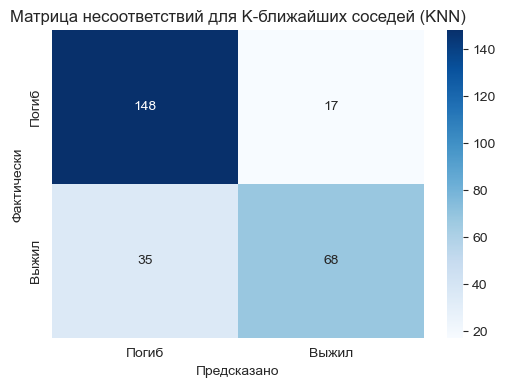

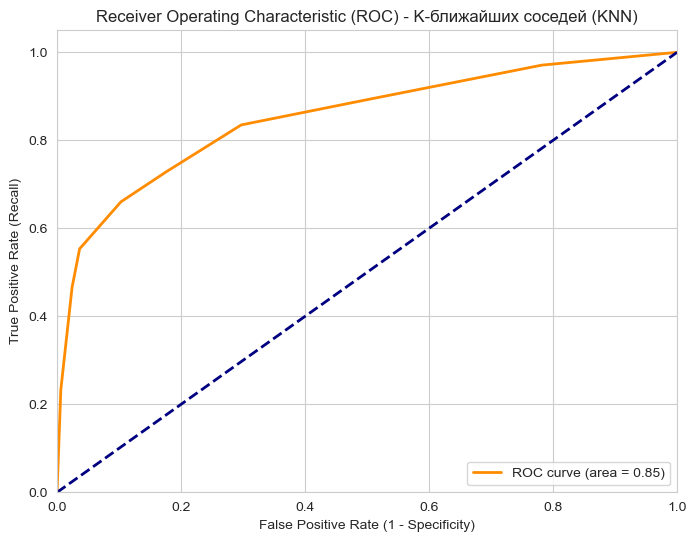

In [20]:
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier())])
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_search_knn.fit(X_train, y_train)
best_knn_model = grid_search_knn.best_estimator_
print(f"Лучшие параметры для KNN: {grid_search_knn.best_params_}")
print(f"Лучший ROC AUC на кросс-валидации: {grid_search_knn.best_score_:.4f}")
evaluate_model("K-ближайших соседей (KNN)", best_knn_model, X_test, y_test)

#### Метод опорных векторов (SVM)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Лучшие параметры для SVM: {'classifier__C': 1, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Лучший ROC AUC на кросс-валидации: 0.8603

--- Метрики для модели: Метод опорных векторов (SVM) ---
Accuracy: 0.7910
Precision: 0.7474
Recall (Полнота): 0.6893
F1-score: 0.7172
ROC AUC: 0.8474
Specificity (Особенность): 0.8545
Fall-out (Выпадение, FPR): 0.1455


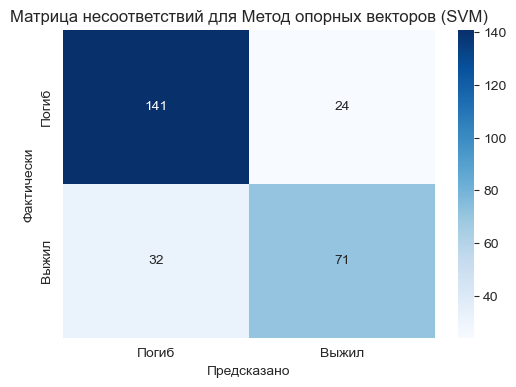

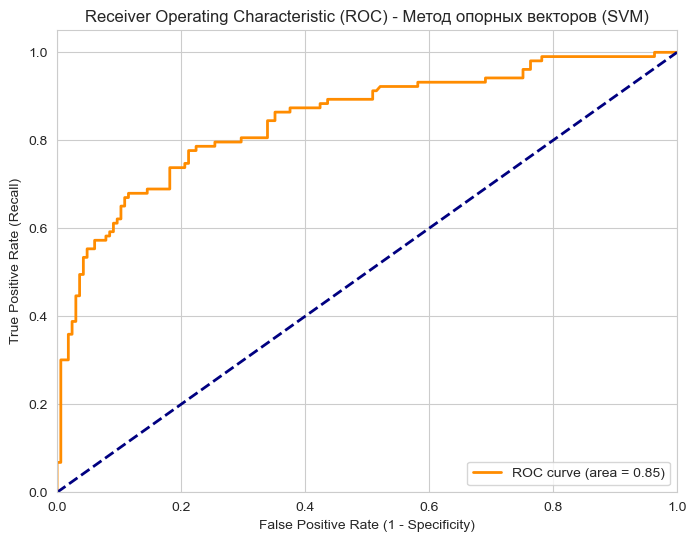

In [21]:
pipeline_svc = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', SVC(random_state=42, probability=True))])
param_grid_svc = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.1, 0.01],
    'classifier__kernel': ['rbf', 'linear', 'poly'] 
}
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svc.fit(X_train, y_train)
best_svc_model = grid_search_svc.best_estimator_
print(f"Лучшие параметры для SVM: {grid_search_svc.best_params_}")
print(f"Лучший ROC AUC на кросс-валидации: {grid_search_svc.best_score_:.4f}")
evaluate_model("Метод опорных векторов (SVM)", best_svc_model, X_test, y_test)

#### Байесовские классификаторы (Гауссовский Наивный Байес)

Лучшие параметры для GaussianNB: {'classifier__var_smoothing': 1.0}
Лучший ROC AUC на кросс-валидации: 0.8360

--- Метрики для модели: Гауссовский Наивный Байес ---
Accuracy: 0.6978
Precision: 0.8235
Recall (Полнота): 0.2718
F1-score: 0.4088
ROC AUC: 0.8474
Specificity (Особенность): 0.9636
Fall-out (Выпадение, FPR): 0.0364


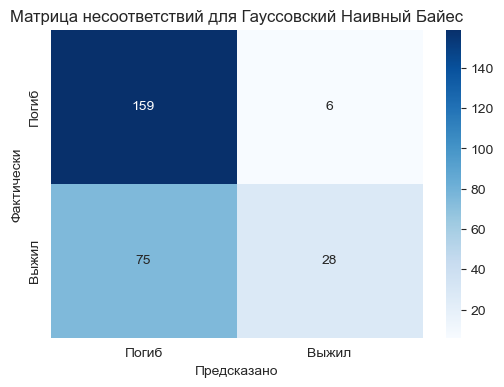

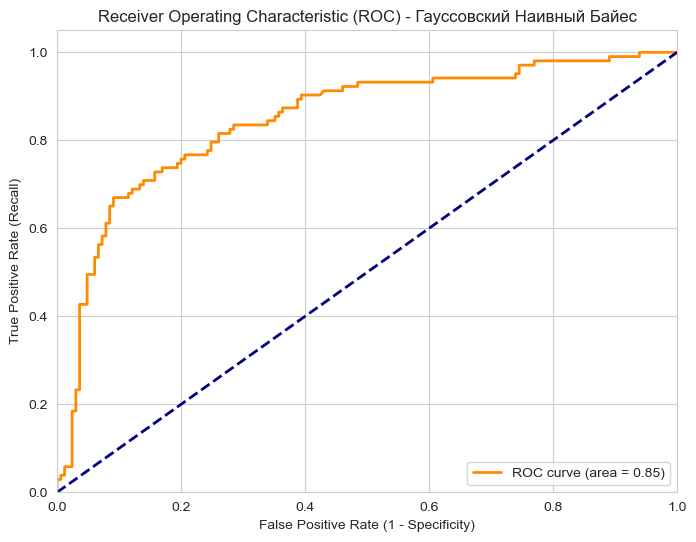

In [22]:
pipeline_gnb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', GaussianNB())])
param_grid_gnb = {
    'classifier__var_smoothing': np.logspace(0,-9, num=100)
}
grid_search_gnb = GridSearchCV(pipeline_gnb, param_grid_gnb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_search_gnb.fit(X_train, y_train)
best_gnb_model = grid_search_gnb.best_estimator_
print(f"Лучшие параметры для GaussianNB: {grid_search_gnb.best_params_}")
print(f"Лучший ROC AUC на кросс-валидации: {grid_search_gnb.best_score_:.4f}")
evaluate_model("Гауссовский Наивный Байес", best_gnb_model, X_test, y_test)

#### Логистическая регрессия

Лучшие параметры для Логистической регрессии: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Лучший ROC AUC на кросс-валидации: 0.8536

--- Метрики для модели: Логистическая регрессия ---
Accuracy: 0.7985
Precision: 0.7634
Recall (Полнота): 0.6893
F1-score: 0.7245
ROC AUC: 0.8492
Specificity (Особенность): 0.8667
Fall-out (Выпадение, FPR): 0.1333


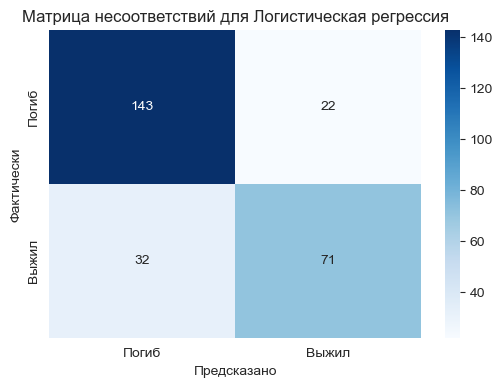

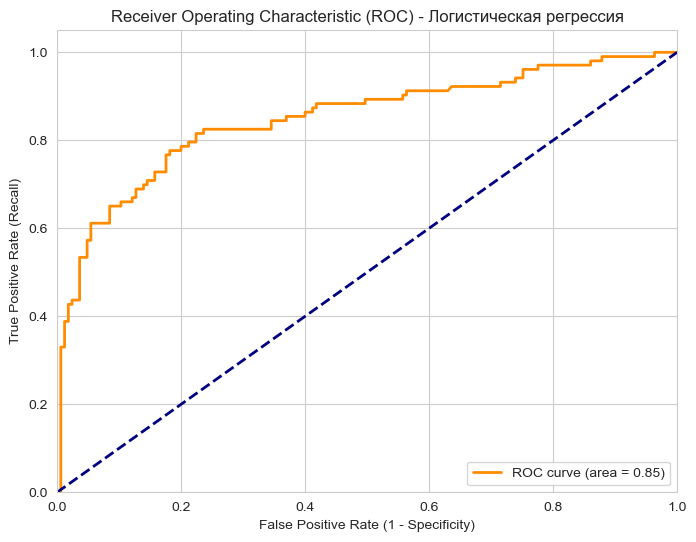

In [23]:
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))])
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_search_lr.fit(X_train, y_train)
best_lr_model = grid_search_lr.best_estimator_
print(f"Лучшие параметры для Логистической регрессии: {grid_search_lr.best_params_}")
print(f"Лучший ROC AUC на кросс-валидации: {grid_search_lr.best_score_:.4f}")
evaluate_model("Логистическая регрессия", best_lr_model, X_test, y_test)

## 8. Написание отчета о проделанной работе

### Общее сравнение всех моделей

In [24]:
metrics_df = pd.DataFrame(all_metrics).T
metrics_df = metrics_df.sort_values(by='ROC_AUC', ascending=False)

print("\n--- Сводная таблица метрик для всех моделей (отсортировано по ROC AUC) ---")
print(metrics_df)


--- Сводная таблица метрик для всех моделей (отсортировано по ROC AUC) ---
                              Accuracy  Precision    Recall        F1  \
K-ближайших соседей (KNN)     0.805970   0.800000  0.660194  0.723404   
Логистическая регрессия       0.798507   0.763441  0.689320  0.724490   
Гауссовский Наивный Байес     0.697761   0.823529  0.271845  0.408759   
Метод опорных векторов (SVM)  0.791045   0.747368  0.689320  0.717172   
Дерево решений (Лучшее)       0.794776   0.875000  0.543689  0.670659   

                               ROC_AUC  Specificity  Fall_out  
K-ближайших соседей (KNN)     0.851809     0.896970  0.103030  
Логистическая регрессия       0.849220     0.866667  0.133333  
Гауссовский Наивный Байес     0.847396     0.963636  0.036364  
Метод опорных векторов (SVM)  0.847396     0.854545  0.145455  
Дерево решений (Лучшее)       0.829509     0.951515  0.048485  
